## Setup / Preliminary Steps

In [76]:
# Import required modules
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.linalg import DenseVector
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

In [77]:
# Set the schema
schema_loanstats = StructType([
    StructField("int_rate", FloatType(), True),
    StructField("loan_amnt", IntegerType(), True),
    StructField("term", IntegerType(), True),
    StructField("grade", StringType(), True),
    StructField("home_ownership", StringType(), True),
    StructField("annual_inc", FloatType(), True),
    StructField("purpose", StringType(), True)])

In [78]:
# Import file to Apache Spark
loanstats = spark.read.format("com.databricks.spark.csv")\
    .option("header","true")\
    .option("inferSchema","true")\
    .schema(schema_loanstats)\
    .load("hdfs://localhost:8020/user/htw/LoanStats.csv")

In [79]:
# Register dataset as Spark SQL
loanstats.createOrReplaceTempView("loanstats")

In [80]:
# Print the schema
loanstats.printSchema()

root
 |-- int_rate: float (nullable = true)
 |-- loan_amnt: integer (nullable = true)
 |-- term: integer (nullable = true)
 |-- grade: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: float (nullable = true)
 |-- purpose: string (nullable = true)



In [81]:
# Move to Pandas dataframe
loanstats_df = loanstats.toPandas()

## Data Understanding

In [82]:
# View first rows
loanstats_df.head()

,int_rate,loan_amnt,term,grade,home_ownership,annual_inc,purpose
0,10.65,5000,36,B,RENT,24000.0,credit_card
1,15.27,2500,60,C,RENT,30000.0,car
2,15.96,2400,36,C,RENT,12252.0,small_business
3,13.49,10000,36,C,RENT,49200.0,other
4,12.69,3000,60,B,RENT,80000.0,other


In [83]:
# View descriptive statistics
loanstats_df.describe()

,int_rate,loan_amnt,term,annual_inc
count,39786.000000,39786.000000,39786.000000,3.978600e+04
mean,12.027873,11231.360277,42.448499,6.897907e+04
std,3.727467,7464.542832,10.638782,6.376264e+04
min,5.420000,500.000000,36.000000,4.000000e+03
25%,9.250000,5500.000000,36.000000,4.050000e+04
50%,11.860000,10000.000000,36.000000,5.900000e+04
75%,14.590000,15000.000000,60.000000,8.234250e+04
max,24.590000,35000.000000,60.000000,6.000000e+06


In [84]:
# Frequency table - Interest rate
int_rate_count = loanstats_df.int_rate.value_counts()
int_rate_count.head(n=10)

10.99    958
13.49    831
11.49    826
7.51     787
7.88     725
7.49     656
11.71    609
9.99     603
7.90     582
5.42     573
Name: int_rate, dtype: int64

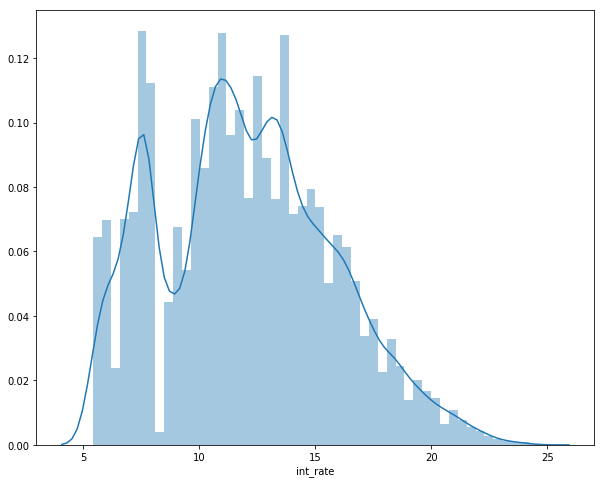

In [85]:
# Frequency charts - Interest rate
loanstats_df
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.distplot(loanstats_df.int_rate);

In [86]:
# Frequency table - Loan amount
loan_amnt_count = loanstats_df.loan_amnt.value_counts()
loan_amnt_count.head(n=10)

10000    2835
12000    2340
5000     2051
6000     1908
15000    1898
20000    1634
8000     1589
25000    1395
4000     1130
3000     1031
Name: loan_amnt, dtype: int64

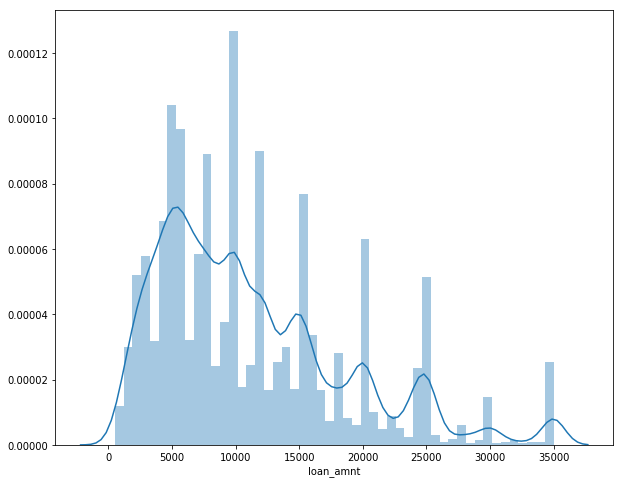

In [87]:
# Frequency charts - Loan amount
loanstats_df
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.distplot(loanstats_df.loan_amnt);

In [88]:
# Frequency table - Term
term_count = loanstats_df.term.value_counts()
term_count.head(n=10)

36    29096
60    10690
Name: term, dtype: int64

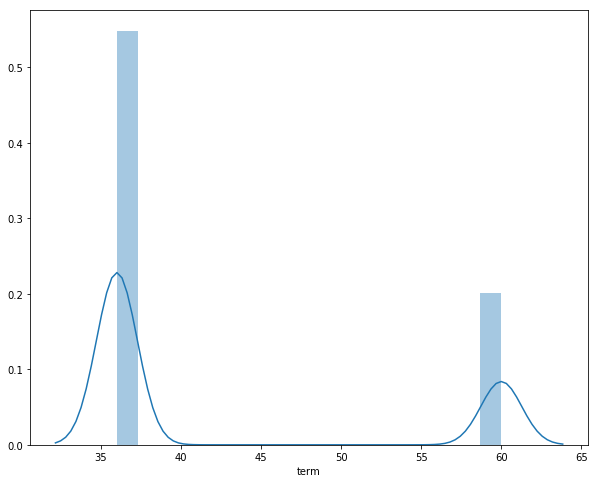

In [89]:
# Frequency charts - Term
loanstats_df
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.distplot(loanstats_df.term);

In [90]:
# Frequency table - Annual income
annual_inc_count = loanstats_df.annual_inc.value_counts()
annual_inc_count.head(n=10)

60000.0    1507
50000.0    1060
40000.0     876
45000.0     834
30000.0     825
75000.0     814
65000.0     804
70000.0     737
48000.0     724
80000.0     663
Name: annual_inc, dtype: int64

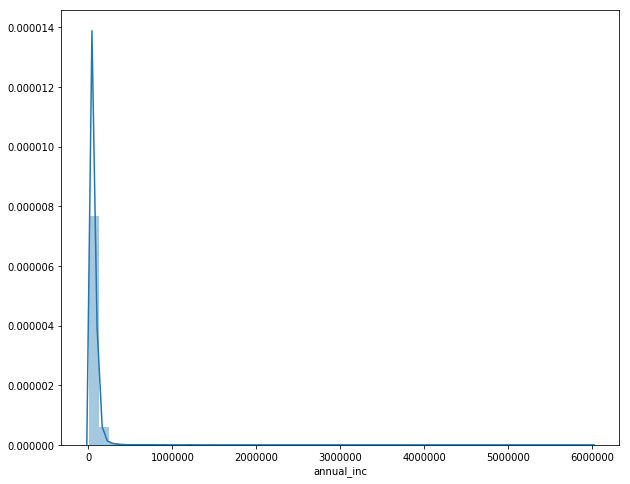

In [91]:
# Frequency charts - Annual income
loanstats_df
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.distplot(loanstats_df.annual_inc);

## Data Preparation

In [92]:
# Check for missing values
loanstats_df.isna().sum() 

int_rate          0
loan_amnt         0
term              0
grade             0
home_ownership    0
annual_inc        0
purpose           0
dtype: int64

In [93]:
# Create dummies for all categorical variables
loanstats_df_dummies = pd.get_dummies(loanstats_df, columns=["grade","home_ownership","purpose"])

In [94]:
loanstats_df_dummies.shape

(39786, 30)

In [95]:
# Identify which dummy columns to drop
loanstats_df_dummies.columns

Index([                  u'int_rate',                  u'loan_amnt',
                             u'term',                 u'annual_inc',
                          u'grade_A',                    u'grade_B',
                          u'grade_C',                    u'grade_D',
                          u'grade_E',                    u'grade_F',
                          u'grade_G',    u'home_ownership_MORTGAGE',
              u'home_ownership_NONE',       u'home_ownership_OTHER',
               u'home_ownership_OWN',        u'home_ownership_RENT',
                      u'purpose_car',        u'purpose_credit_card',
       u'purpose_debt_consolidation',        u'purpose_educational',
         u'purpose_home_improvement',              u'purpose_house',
           u'purpose_major_purchase',            u'purpose_medical',
                   u'purpose_moving',              u'purpose_other',
         u'purpose_renewable_energy',     u'purpose_small_business',
                 u'purpose_vacatio

In [96]:
# To drop one dummy column from each variable
loanstats_df_dummies = loanstats_df_dummies.drop(columns=["grade_G","home_ownership_RENT","purpose_wedding"])

In [97]:
loanstats_df_dummies.shape

(39786, 27)

### Split into train and test datasets

In [98]:
# Obtain list of columns
loanstats_df_dummies.columns.tolist()

['int_rate',
 'loan_amnt',
 'term',
 'annual_inc',
 u'grade_A',
 u'grade_B',
 u'grade_C',
 u'grade_D',
 u'grade_E',
 u'grade_F',
 u'home_ownership_MORTGAGE',
 u'home_ownership_NONE',
 u'home_ownership_OTHER',
 u'home_ownership_OWN',
 u'purpose_car',
 u'purpose_credit_card',
 u'purpose_debt_consolidation',
 u'purpose_educational',
 u'purpose_home_improvement',
 u'purpose_house',
 u'purpose_major_purchase',
 u'purpose_medical',
 u'purpose_moving',
 u'purpose_other',
 u'purpose_renewable_energy',
 u'purpose_small_business',
 u'purpose_vacation']

In [99]:
# Step 1: Initialise - only features
vectorAssembler = VectorAssembler(inputCols = ['loan_amnt',
 'term',
 'annual_inc',
 'grade_A',
 'grade_B',
 'grade_C',
 'grade_D',
 'grade_E',
 'grade_F',
 'home_ownership_MORTGAGE',
 'home_ownership_NONE',
 'home_ownership_OTHER',
 'home_ownership_OWN',
 'purpose_car',
 'purpose_credit_card',
 'purpose_debt_consolidation',
 'purpose_educational',
 'purpose_home_improvement',
 'purpose_house',
 'purpose_major_purchase',
 'purpose_medical',
 'purpose_moving',
 'purpose_other',
 'purpose_renewable_energy',
 'purpose_small_business',
 'purpose_vacation'], outputCol = 'features')

In [100]:
# Step 1a: Convert pandas df to spark df
loanstats_df_spark = sqlContext.createDataFrame(loanstats_df_dummies)

In [101]:
# Step 2: Apply (transform) to loanstats DataFrame
loanstats_input_df = vectorAssembler.transform(loanstats_df_spark)

In [102]:
# Step 3: Select transformed variables and target variable
loanstats_input_df = loanstats_input_df.select(['features', 'int_rate'])

In [103]:
# Step 4: Inspect the dataset
loanstats_input_df.toPandas().head(n=10)

,features,int_rate
0,"(5000.0, 36.0, 24000.0, 0.0, 1.0, 0.0, 0.0, 0....",10.650000
1,"(2500.0, 60.0, 30000.0, 0.0, 0.0, 1.0, 0.0, 0....",15.270000
2,"(2400.0, 36.0, 12252.0, 0.0, 0.0, 1.0, 0.0, 0....",15.960000
3,"(10000.0, 36.0, 49200.0, 0.0, 0.0, 1.0, 0.0, 0...",13.490000
4,"(3000.0, 60.0, 80000.0, 0.0, 1.0, 0.0, 0.0, 0....",12.690000
5,"(5000.0, 36.0, 36000.0, 1.0, 0.0, 0.0, 0.0, 0....",7.900000
6,"(7000.0, 60.0, 47004.0, 0.0, 0.0, 1.0, 0.0, 0....",15.960000
7,"(3000.0, 36.0, 48000.0, 0.0, 0.0, 0.0, 0.0, 1....",18.639999
8,"(5600.0, 60.0, 40000.0, 0.0, 0.0, 0.0, 0.0, 0....",21.280001
9,"(5375.0, 60.0, 15000.0, 0.0, 1.0, 0.0, 0.0, 0....",12.690000


In [104]:
# Split into train & test datasets
train_data, test_data = loanstats_input_df.randomSplit(weights=[.8,.2], seed=42)

In [105]:
train_data.toPandas().shape[0]

31813

In [106]:
test_data.toPandas().shape[0]

7973

## Modelling

### Run linear regression on train set

In [107]:
# Initialise the model
lr = LinearRegression(labelCol="int_rate",
                      maxIter=10000, 
                      regParam=.0, 
                      elasticNetParam=.0)

In [108]:
# Fitting the model
linearModel = lr.fit(train_data)

In [109]:
# R2 of linear model
print("R2: " + str(linearModel.summary.r2 * 100) + "%")

R2: 92.4702899762%


### Check residuals (train set)

In [110]:
# Copy the residuals to a Pandas DataFrame
linear_model_residuals = linearModel.summary.residuals.toPandas()

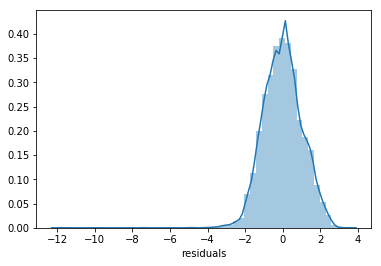

In [111]:
sns.distplot(a=linear_model_residuals['residuals'], kde = True)

### Perform prediction on test set

In [112]:
lr_predictions_test = linearModel.transform(test_data)

In [113]:
lr_predictions_test.toPandas().head()

,features,int_rate,prediction
0,"(1800.0, 36.0, 50400.0, 1.0, 0.0, 0.0, 0.0, 0....",8.90,7.250371
1,"(2000.0, 36.0, 15600.0, 1.0, 0.0, 0.0, 0.0, 0....",7.90,7.254291
2,"(2400.0, 36.0, 48000.0, 1.0, 0.0, 0.0, 0.0, 0....",8.49,7.259395
3,"(4800.0, 36.0, 30000.0, 1.0, 0.0, 0.0, 0.0, 0....",7.49,7.295718
4,"(5000.0, 36.0, 40000.0, 1.0, 0.0, 0.0, 0.0, 0....",8.90,7.298436


### Check residuals (test set)

In [114]:
lr_predictions_pd = lr_predictions_test.toPandas()

In [115]:
lr_predictions_pd['residuals'] = lr_predictions_pd['int_rate'] - lr_predictions_pd['prediction']

In [116]:
lr_predictions_pd.head()

,features,int_rate,prediction,residuals
0,"(1800.0, 36.0, 50400.0, 1.0, 0.0, 0.0, 0.0, 0....",8.90,7.250371,1.649628
1,"(2000.0, 36.0, 15600.0, 1.0, 0.0, 0.0, 0.0, 0....",7.90,7.254291,0.645709
2,"(2400.0, 36.0, 48000.0, 1.0, 0.0, 0.0, 0.0, 0....",8.49,7.259395,1.230604
3,"(4800.0, 36.0, 30000.0, 1.0, 0.0, 0.0, 0.0, 0....",7.49,7.295718,0.194282
4,"(5000.0, 36.0, 40000.0, 1.0, 0.0, 0.0, 0.0, 0....",8.90,7.298436,1.601563


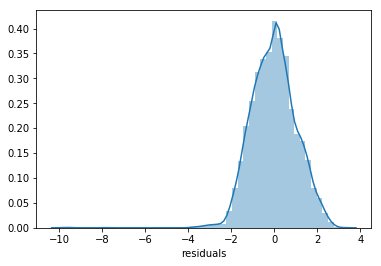

In [117]:
sns.distplot(a=lr_predictions_pd['residuals'], kde = True)

#### As residuals are normally distributed for both train and test sets, it can be concluded that they are not "problematic". The R2 of 92.5% suggests that the model is of relatively good quality. Therefore there is no need to refine the linear model or to run a second time with modified features. 